* Enregistrement...
* Enregistré


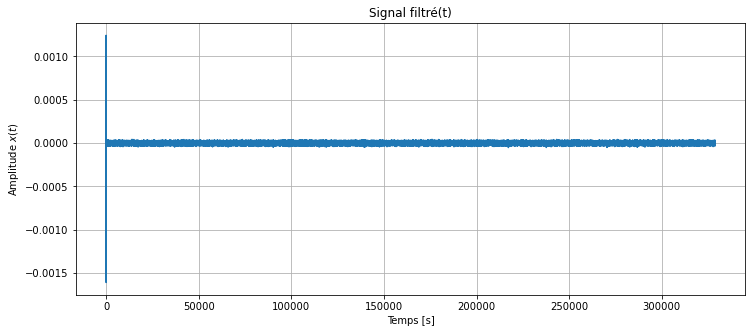

IndexError: too many indices for array

In [4]:
#------------- Importation des modules -----------------


import pyaudio   #Importion du module PyAudio (émettre le son)
import wave      #Importion du module wave (lire, telecharger ou jouer un fichier Wav)
import numpy as np #Importion du module numpy (taleau à deux dimensions, PI, fonction maths (sin, cos, etc...))
import matplotlib.pyplot as plt #Importion du module matplotlib.pyplot (Graphique)
import binascii   #Importion du module binascii (conversion binaire / ascii, )
from os.path import abspath   #Importion du module abspath permettant de donner l'endroit ou se trouve un fichire (quand il est téléchargé par exemple)
import time  #Importion du module(créer des pauses dans le programme)
import soundfile as sf      #Importion du module soundfile permettant de traiter des fichiers sons
import sounddevice as sd    #Importion du module sounddevice fournissant des fonctions pour lire et enregistrer des tableaux numpy contenant des signaux audios
import scipy.io.wavfile #Importation tu module scipy.io permettant d'obtenir de nombreux modules, classes et fonctions disponibles pour lire et écrire des données dans une variété de formats de fichiers
import scipy.signal as sig  #Importation du module scipy.signal permettant de filtrer une séquence de données à l'aide d'un filtre numérique
from scipy.signal import butter, filtfilt, lfilter #Importation des modules butter, filtfilt et lfilter du module scipy.signal (nous avons rajouté cette ligne car en l'enlevant, le programme ne fonctionnait plus, dû à un bug)
from functools import partial #Importation du module partials de functools permettant d'appeler un objet partiel (ce sont des objets appelables créees par le module partial)


# --------- Création de la fonction décodage --------


def xor(a, b): # Création d'une fonction contenant les résultats et ayant 2 paramètres
   
    # Initialiser le résultat
    result = [] 
   

    for i in range(1, len(b)): 
        if a[i] == b[i]:         # Si les bits sont idem, alors XOR vaut 0
            result.append('0') 
        else: 
            result.append('1')  #Sinon, XOR vaut 1
   
    return ''.join(result)   #Retourne le résultat
   

def mod2div(divident, divisor):  # Division euclidienne pour le crc
   
    pick = len(divisor) #la variable pick prend en valeur la taille du tableau du paramètre divisor
    tmp = divident[0 : pick] 
   
    while pick < len(divident): 
   
        if tmp[0] == '1': 

            tmp = xor(divisor, tmp) + divident[pick] 
   
        else:    
            tmp = xor('0'*pick, tmp) + divident[pick] 
    
        pick += 1
    
    if tmp[0] == '1': 
        tmp = xor(divisor, tmp) 
    else: 
        tmp = xor('0'*pick, tmp) 
   
    checkword = tmp 
    return checkword   #Retourne le résultat de la division

def decodeData(data_crc, Clé):   #Création de la fonction decodeData qui permettra de recomparer les clés CRC afin de détecter si il ya eu une erreur 
    l_Clé = len(Clé)  #La variable l_clé prend en valeur la taille du tableau clé
    appended_data = data_crc + '0'*(l_Clé-1) 
    remainder = mod2div(appended_data, Clé) 
   
    return remainder 


# --------- Création du filtre passe-bande ----------


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5): #Création de la fonction passe-bande
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# -------------Reception ---------------


CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
fs = 47000
RATE = 47000
Fe = 47000
RECORD_SECONDS = 7
Clé = '10011'

WAVE_OUTPUT_FILENAME = "Son_recu.wav"

p = pyaudio.PyAudio()
 
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)
 
print("* Enregistrement...")
 
frames = []
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)): #Enregistrement du message
    data = stream.read(CHUNK) #Enregistrement du son arrivant dans le microphone
    frames.append(data) #Tableau frames prend les valeurs enregistrés
 
print("* Enregistré")
 
stream.stop_stream()
stream.close()
p.terminate()
 
 
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb') #Sauvegarde du message enregistré
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()


signal, Fe = sf.read(r'Son_recu.wav') #La variable signal prend en valeur le son enregistré



# -------------- Filtrage --------------------
  

time.sleep(0.5)

with open("Son_recu.wav", "rb") as file_in:
    with open("Binaire.txt", "w") as file_out:
        for byte in iter(partial(file_in.read, 1), b''):
            file_out.write(format(ord(byte), '0>8b'))
            

lowcut = 10000.0
highcut = 22000.0
order = 6

y = butter_bandpass_filter(signal, lowcut, highcut, fs, order=6)

plt.figure (figsize = (12,5))
plt.grid(True)
plt.plot(y)
plt.xlabel('Temps [s]')
plt.ylabel("Amplitude $x(t)$")
plt.title('Signal filtré(t)')
plt.show()

Nbits = len(y)    #Nombre de bits initial (taille du message entré en binaire)
baud = 100   #Débit de transmission en bit/seconde
Ns = int(Fe/baud)        #Nombre de symboles par bit (Fréq d'echan / Débit binaire) 
N = int(Nbits * Ns)   #Nombre de bits totals


# ------------ Démodulation -----------------3


N = len(y)   #N prend la valeur du nombre de valeurs présentes dans la liste y qui est le signal filtré
T = np.arange(0.0, 2*(N/2))/Fe   #Vecteur temps des porteuses de démodulation


Fp1 = 23000     #Fréquence de la porteuse 1
Fp2 = 21000     #Fréquence de la porteuse 2

A1 = 1   #Amplitude de la porteuse 1
A2 = 1   #Amplitude de la porteuse 2

S1 = A1*np.sin(2*np.pi*Fp1*T) #Utilisation de la même formule des porteuses que pour envoyer le message
S2 = A2*np.sin(2*np.pi*Fp2*T) #Utilisation de la même formule des porteuses que pour envoyer le message

bit1 = y[:, 1]*S1  #La variable bit1 prend en valeur le produit de la deuxième colonne de y et S1
bit0 = y[:, 1]*S2  #La variable bit1 prend en valeur le produit de la deuxième colonne de y et S2
   
y1 = [] #Création d'un tableau y1
y2 = [] #Création d'un tableau y2

z=0
for z in range(0, 2*N, Ns):
    y1.append(np.trapz(bit1[z:z+Ns],T[z:z+Ns]))
    y2.append(np.trapz(bit0[z:z+Ns],T[z:z+Ns]))
    
    
comparateur = (np.array(y1) > np.array(y2))

# ------------ Définition de la fonction décodage -------------


data = str(signal)

def encodeData(data, Clé): 
    l_Clé = len(Clé) 

    appended_data = data + '0'*(l_Clé-1) 
    
    remainder = mod2div(appended_data, Clé) 
   

    codeword = data + remainder 
    return codeword


# ------------ Liste pour stocker le message démodulé -----------------


data_crc= encodeData(data,Clé)

Message_démodule = []

for ii in range (0, len(comparateur)):
    
    if comparateur [ii] == False:
        Message_démodule.extend([int(0)])
        
    if comparateur [ii] == True:
         Message_démodule.extend([int(1)])
        
             

print("Le message binaire démodulé est:\n ", Message_démodule)



       
# -------------- Décodage du message -----------------


Message_decode = [] #Création d'un tableau

for w in range (0, len(Message_démodule), 2): #De 0 jusque la fin de la liste "Message_démodule" avec un pas de 2 car on utilise un décodage synchrone Manchester
    Message_decode.extend(str(Message_démodule[w]))
    
    
Message_decode = list(map(int, Message_decode))  
check = decodeData(str(Message_decode), Clé) #La variable check prend la valeur de


for valeur in range(0, len(Message_decode), 8):
    print("Le reste de la division après décodage est -> " + check) 
    temp = "0" * (len(Clé) - 1) 


# -------- Conversion binaire ASCII ---------


bin_data = ""  #Création d'une variable pouvant contenir des caractères
for elem in Message_decode:   #Pour chaque élement dans le tableau message_decode
    bin_data += str(elem)  #Bin_data prend la valeur du tableau en string
    
data_reçu =' ' #Création d'une variable pouvant contenir des caractères

def BinaryToDecimal(binary):  #Création d'une fonction pouvant convertir le mesasge binaire en décimal
    binary1 = binary #La variable binary1 prend la valeur binary
    decimal, i, n = 0, 0, 0 #initialisation des variables
    
    while(binary != 0): #Tant que binary n'est pas égal à 0
        dec = binary % 10  #La variable dec prend binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return (decimal) #Retourne la valeur finale

for i in range(0, len(bin_data), 8): 
    temp_data = int(bin_data[i+1:i+8]) #Utilisation de temp_data pour obtenir la valeur décimale correspondante de (temp_data)
      
    decimal_data = BinaryToDecimal(temp_data) #La variable decimal_data prend la BinaryToDecimal valeur de temp_data après être passé dans la fonction

    

    # Décodage de la valeur décimale renvoyée par la fonction BinarytoDecimal en utilisant char(decimal_data)
    data_reçu = data_reçu + chr(decimal_data) 


print("Le message reçu est :", data_reçu) #Affichage du message reçu, démodulé, décodé et reconverti en ASCII.    